In [1]:
import networkx as nx
from scipy.sparse import linalg as scp_sla
import numpy as np
import matplotlib.pyplot as plt

import sim_lib.util as util
import sim_lib.graph_networkx as gnx
import sim_lib.attr_lib.util as attr_util
from sim_lib.attr_lib.formation import *
import sim_lib.attr_lib.vis as vis

In [2]:
_N = 1

params = {
    'context_count' : 8,
    'k' : 8,
    'attr_func' : attr_util.discrete_pareto_val, # attribute assignment function
    'edge_util_func' : attr_util.max_inv_frequency,
    'edge_proposal' : attr_util.const_one,
    'vtx_util' : attr_util.logistic,
    'edge_selection' : attr_util.seq_projection_edge_edit,
    'attr_copy' : attr_util.freq_attr_copy,
    'seed_type' : 'clique', # Type of seed network
    'max_clique_size' : 150,
    'vtx_types' :
        {
            'wide' : { 'likelihood' : 0.0,
                      'struct_util' : attr_util.degree_util,
                      'color' : 'blue' },
            'tall' : { 'likelihood' : 1.0,
                      'struct_util' : attr_util.potential_density,
                      'color' : 'red' }
        }
}

assert sum([ t['likelihood'] for t in params['vtx_types'].values() ]) == 1.0

In [3]:
def graph_density(G):
    denum = (G.num_people * (G.num_people - 1))
    num = sum([ v.degree for v in G.vertices])
    return num / denum

def second_eigv(G_nx):
    laplacian = nx.linalg.laplacianmatrix.normalized_laplacian_matrix(G_nx)
    eigvals = scp_sla.eigs(laplacian.toarray(), return_eigenvectors=False)
    eigvals.sort()
    return eigvals[1]

def apl(G_nx):
    return nx.average_shortest_path_length(G_nx)

def diam(G_nx):
    return nx.diameter(G_nx)

def social_edge_welfare(G):
    return sum([ v.total_edge_util for v in G.vertices ]) / 2

def modularity(G_nx):
    partitions = nx_comm.greedy_modularity_communities(G_nx)
    return nx_comm.modularity(G_nx, partitions)

def print_metrics(G):
    G_nx = gnx.graph_to_nx(G)
    G_nx_largest = G_nx.subgraph(max(nx.connected_components(G_nx), key=len))
    
    largest_size = len(G_nx_largest)
    gd = graph_density(G)
    avg_pl = apl(G_nx_largest)
    diameter = diam(G_nx_largest)
    eig2 = second_eigv(G_nx_largest)
    
    print(f"""Largest component size: {largest_size}
graph density: {gd}, \n
average path length: {avg_pl}, \n
diameter: {diameter}, \n
second eigenvalue: {eig2} \n""")

In [4]:
def plot_distributions(G):
    
    # Degree distribution
    degree_dist = [ v.degree for v in G.vertices ]
    norm_degree_dist = []
    if max(degree_dist) == 0:
        norm_degree_dist = [ 0 for d in degree_dist ]
    else:
        norm_degree_dist = [ d / max(degree_dist) for d in degree_dist ]
    
    G_nx = gnx.graph_to_nx(G)
    eigv_centralities = nx.eigenvector_centrality(G_nx, weight='util')
    eigv_centralities = list(eigv_centralities.values())
    
    metric_dists = [norm_degree_dist, eigv_centralities]
    dist_labels = ['norm degree', 'eigenvector cent']
    
    bins = np.linspace(0, 1, 100)
    plt.hist(metric_dists, bins, alpha=0.5, label=dist_labels)
    plt.legend(loc='upper right')
    plt.show()
    

{'context_count': 8, 'k': 8, 'attr_func': <function discrete_pareto_val at 0x7f20e26d6048>, 'edge_util_func': <function max_inv_frequency at 0x7f20e299a598>, 'edge_proposal': <function const_one at 0x7f20e299abf8>, 'vtx_util': <function logistic at 0x7f20e299ab70>, 'edge_selection': <function seq_projection_edge_edit at 0x7f20e299ae18>, 'attr_copy': <function freq_attr_copy at 0x7f20e26d6158>, 'seed_type': 'clique', 'max_clique_size': 150, 'vtx_types': {'wide': {'likelihood': 0.0, 'struct_util': <function degree_util at 0x7f20e299aa60>, 'color': 'blue'}, 'tall': {'likelihood': 1.0, 'struct_util': <function direct_util_buffer.<locals>.ut_func_wrapper at 0x7f20e299a7b8>, 'color': 'red'}}, 'direct_cost': 0.004920078578092445, 'indirect_cost': 2.4207173214604176e-05}
-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [Vertex 0]}
Vertex 0 degree 0
[(1.0, 0.005896641078092445, -0.004920078578092445)]
[0.4980282419609538]
[Vertex 1]
chose 0 (1.0, 0.00589664107809244

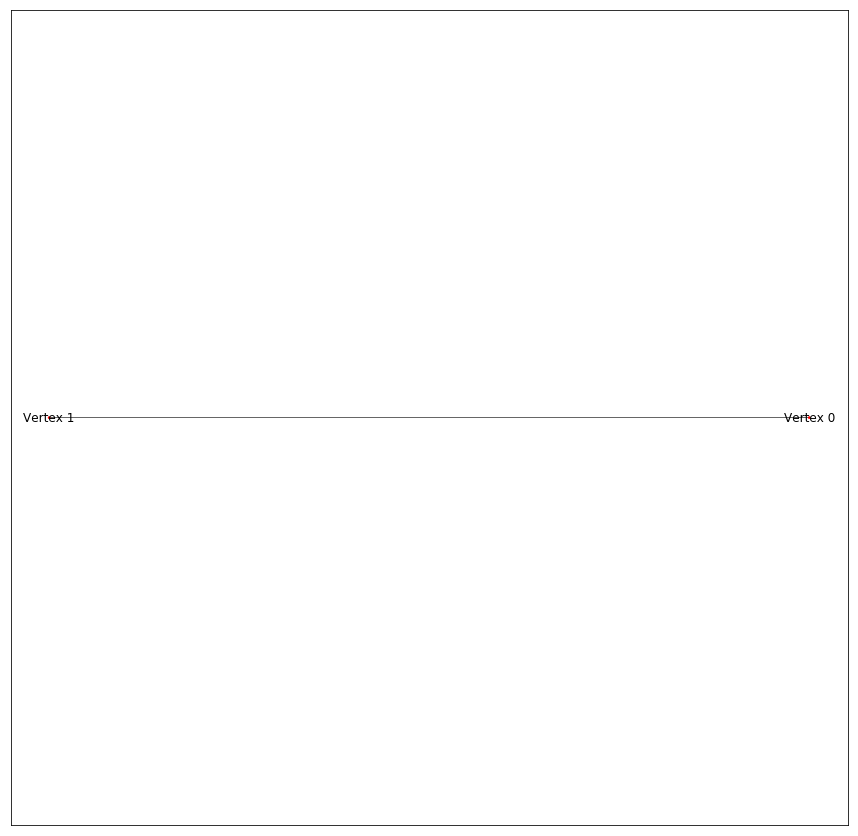

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [Vertex 1, Vertex 0]}
Vertex 0 degree 1
[(0.6666666666666666, 0.005896641078092445, -0.004920078578092445), (-0.6666666666666666, -0.005896641078092445, 0.004920078578092445)]
[0.33136157529428706, -0.33136157529428706]
[Vertex 2, (Vertex 2, Vertex 1)]
chose 0 (0.6666666666666666, 0.005896641078092445, -0.004920078578092445)
chosen vtx Vertex 2
chose to add
###########################
Vertex 1 degree 1
[(1.0, 0.005986126536705421, -0.004944285751307049), (-0.6666666666666666, -0.005896641078092445, 0.004920078578092445)]
[0.4980487775170456, -0.33136157529428706]
[Vertex 2, (Vertex 2, Vertex 0)]
chose 0 (1.0, 0.005986126536705421, -0.004944285751307049)
chosen vtx Vertex 2
chose to add
###########################
Vertex 2 had no options
walk lengths {Vertex 0: 9, Vertex 1: 9, Vertex 2: 9}


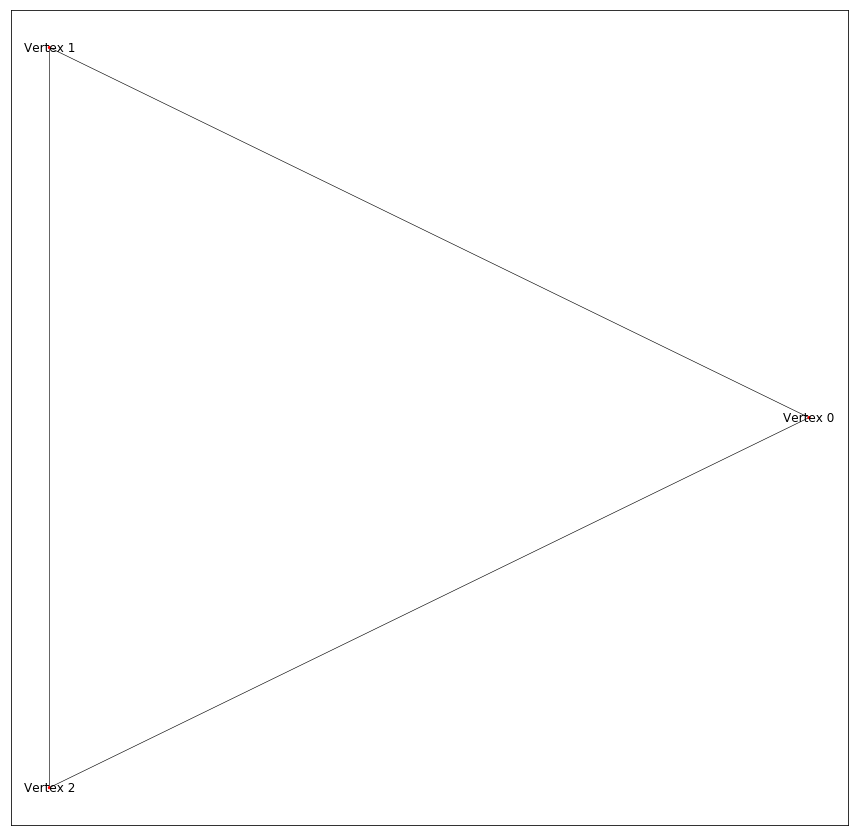

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [Vertex 1, Vertex 2, Vertex 0]}
Vertex 0 degree 2
[(1.0, 0.005896641078092445, -0.004920078578092445), (-0.5, -0.005986126536705421, 0.004944285751307049), (-0.33333333333333337, -0.005986126536705421, 0.004944285751307049)]
[0.4980282419609538, -0.24804877751704565, -0.16471544418371237]
[Vertex 3, (Vertex 3, Vertex 2), (Vertex 3, Vertex 1)]
chose 0 (1.0, 0.005896641078092445, -0.004920078578092445)
chosen vtx Vertex 3
chose to add
###########################
Vertex 1 degree 2
[(0.6666666666666665, 0.005986126536705423, -0.004944285751307049), (-0.7499999999999999, -0.005986126536705421, 0.004944285751307049), (-0.4166666666666665, -0.005986126536705421, 0.004944285751307049)]
[0.3313821108503789, -0.37304877751704557, -0.20638211085037894]
[Vertex 3, (Vertex 3, Vertex 2), (Vertex 3, Vertex 0)]
chose 0 (0.6666666666666665, 0.005986126536705423, -0.004944285751307049)
chosen vtx Ve

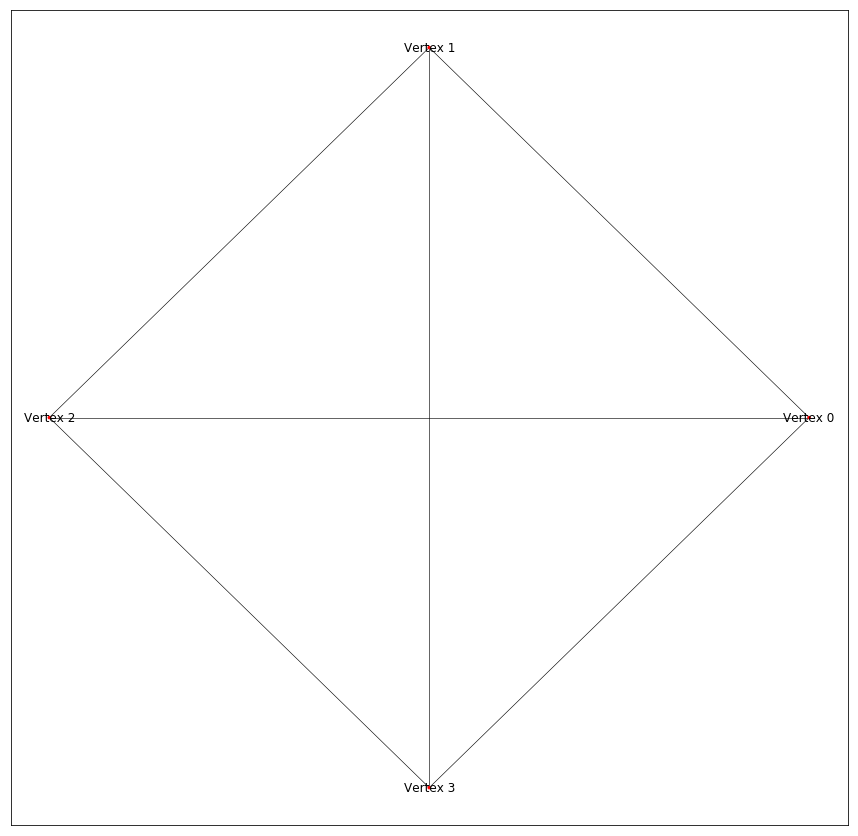

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [Vertex 1, Vertex 2, Vertex 0, Vertex 3]}
Vertex 0 degree 3
[(0.6666666666666667, 0.005896641078092443, -0.004920078578092445), (-0.7999999999999998, -0.006075611995318397, 0.004968492924521653), (-0.3333333333333332, -0.006075611995318397, 0.004968492924521653), (0.13333333333333358, -0.006075611995318397, 0.004968492924521653)]
[0.3313615752942871, -0.3980693130731374, -0.16473597973980417, 0.06859735359352925]
[Vertex 4, (Vertex 4, Vertex 3), (Vertex 4, Vertex 1), (Vertex 4, Vertex 2)]
chose 0 (0.6666666666666667, 0.005896641078092443, -0.004920078578092445)
chosen vtx Vertex 4
chose to add
###########################
Vertex 1 degree 3
[(0.6666666666666667, 0.0059861265367054176, -0.004944285751307049), (-0.5333333333333332, -0.006075611995318397, 0.004968492924521653), (-0.6666666666666664, -0.006075611995318397, 0.004968492924521653), (-0.9999999999999998, -0.006

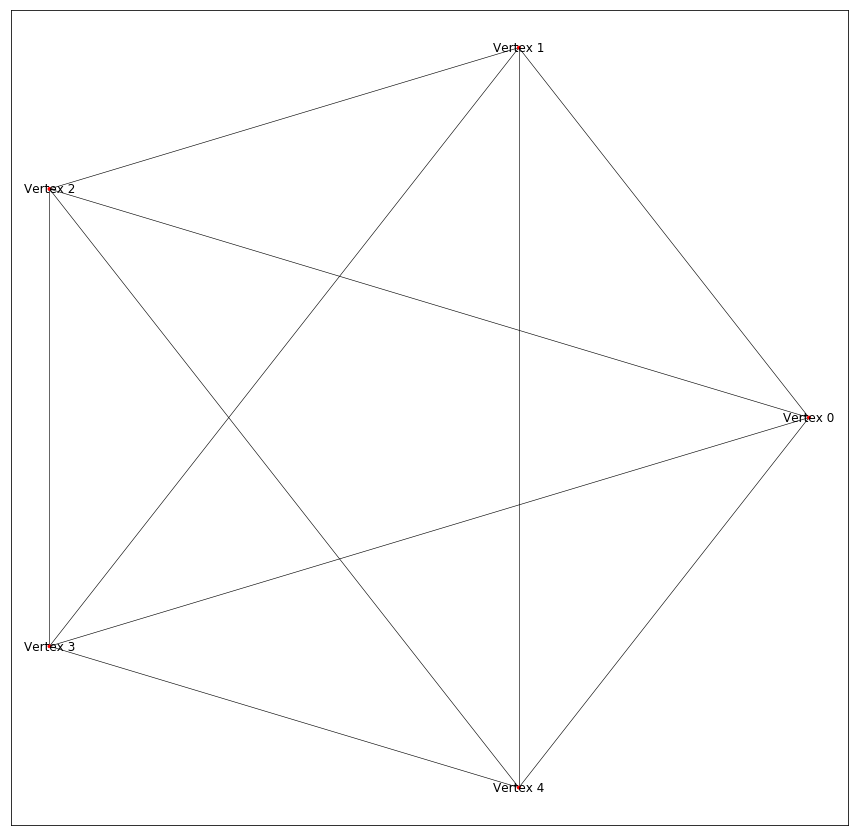

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [], Vertex 5: [Vertex 2, Vertex 0, Vertex 3, Vertex 1, Vertex 4]}
Vertex 0 degree 4
[(0.6666666666666666, 0.005896641078092443, -0.004920078578092443), (-0.5555555555555559, -0.0061650974539313695, 0.0049927000977362575), (-0.3888888888888893, -0.0061650974539313695, 0.0049927000977362575), (-0.22222222222222263, -0.0061650974539313695, 0.0049927000977362575), (-0.05555555555555595, -0.0061650974539313695, 0.0049927000977362575)]
[0.33136157529428706, -0.27586762640700735, -0.19253429307367406, -0.10920095974034075, -0.025867626407007398]
[Vertex 5, (Vertex 5, Vertex 4), (Vertex 5, Vertex 1), (Vertex 5, Vertex 2), (Vertex 5, Vertex 3)]
chose 0 (0.6666666666666666, 0.005896641078092443, -0.004920078578092443)
chosen vtx Vertex 5
chose to add
###########################
Vertex 1 degree 4
[(0.39999999999999974, 0.0059861265367054176, -0.0049442857513070475), (-0.55555555

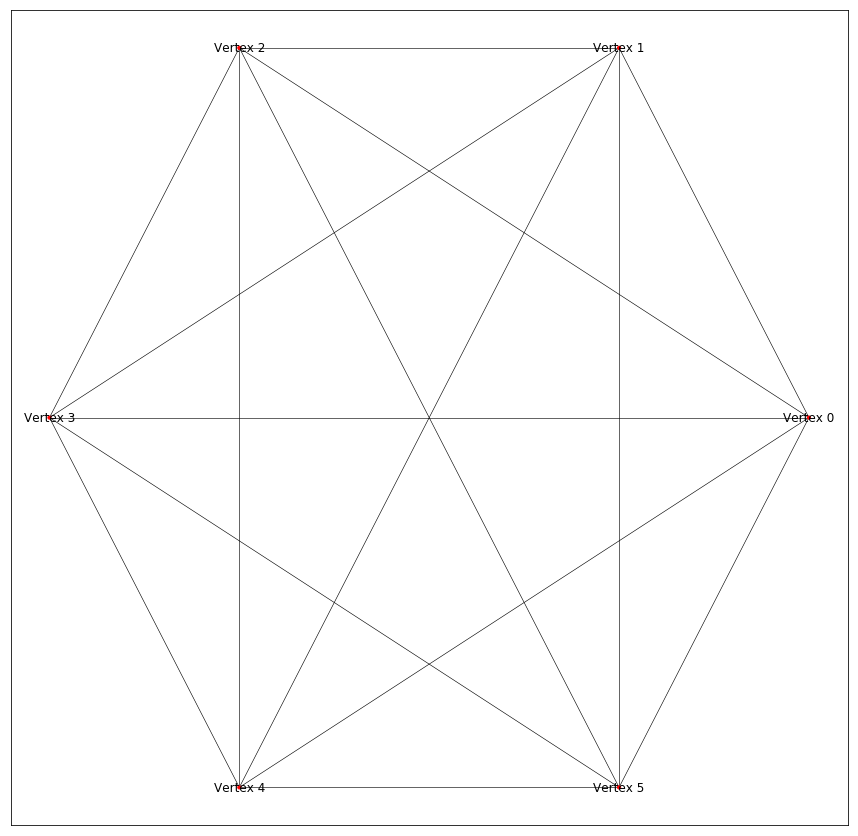

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [], Vertex 5: [], Vertex 6: [Vertex 2, Vertex 0, Vertex 3, Vertex 4, Vertex 5, Vertex 1]}
Vertex 0 degree 5
[(0.33333333333333315, 0.005896641078092454, -0.004920078578092447), (-0.5714285714285714, -0.006254582912544344, 0.00501690727095086), (-0.9285714285714286, -0.006254582912544344, 0.00501690727095086), (-0.7857142857142857, -0.006254582912544344, 0.00501690727095086), (-0.35714285714285715, -0.006254582912544344, 0.00501690727095086), (-0.21428571428571427, -0.006254582912544344, 0.00501690727095086)]
[0.16469490862762035, -0.283824669899607, -0.4623960984710356, -0.3909675270424642, -0.17668181275674988, -0.10525324132817845]
[Vertex 6, (Vertex 6, Vertex 5), (Vertex 6, Vertex 1), (Vertex 6, Vertex 2), (Vertex 6, Vertex 3), (Vertex 6, Vertex 4)]
chose 0 (0.33333333333333315, 0.005896641078092454, -0.004920078578092447)
chosen vtx Vertex 6
chose to add
#########

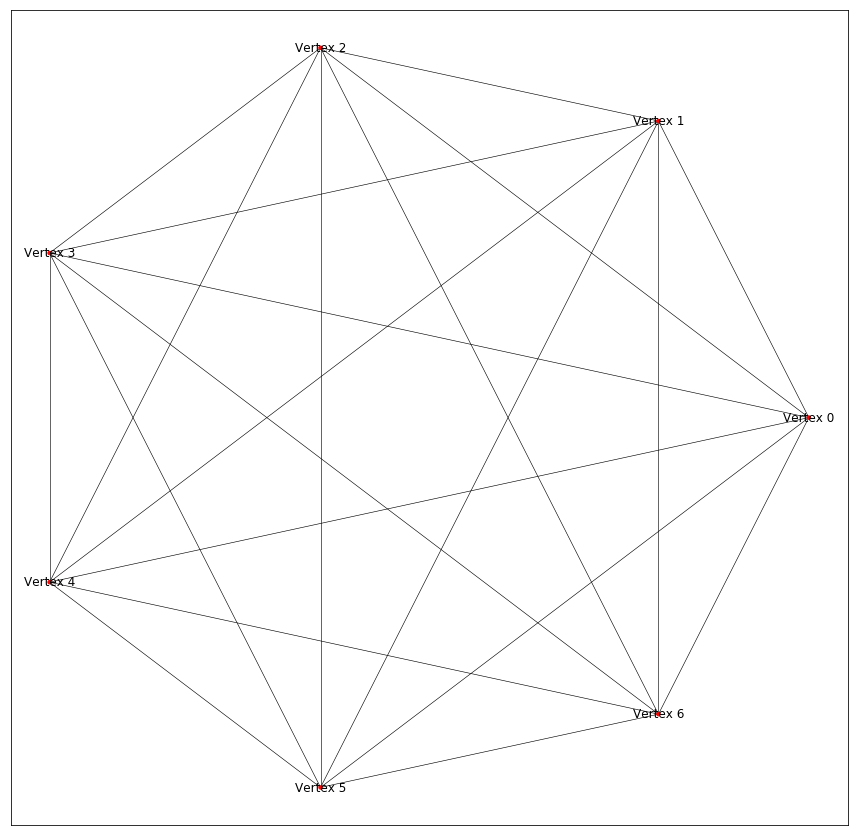

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [], Vertex 5: [], Vertex 6: [], Vertex 7: [Vertex 2, Vertex 0, Vertex 3, Vertex 6, Vertex 1, Vertex 5, Vertex 4]}
Vertex 0 degree 6
[(0.40000000000000036, 0.005896641078092443, -0.00492007857809245), (-0.29166666666666696, -0.006344068371157325, 0.005041114444165468), (-0.666666666666667, -0.006344068371157325, 0.005041114444165468), (-0.8750000000000004, -0.006344068371157325, 0.005041114444165468), (-0.7500000000000004, -0.006344068371157325, 0.005041114444165468), (-0.9583333333333339, -0.006344068371157325, 0.005041114444165468), (-0.7291666666666674, -0.006344068371157325, 0.005041114444165468)]
[0.19802824196095395, -0.14396425307474667, -0.3314642530747467, -0.43563091974141344, -0.37313091974141344, -0.4772975864080802, -0.3627142530747469]
[Vertex 7, (Vertex 7, Vertex 6), (Vertex 7, Vertex 1), (Vertex 7, Vertex 2), (Vertex 7, Vertex 3), (Vertex 7, Vertex 4), 

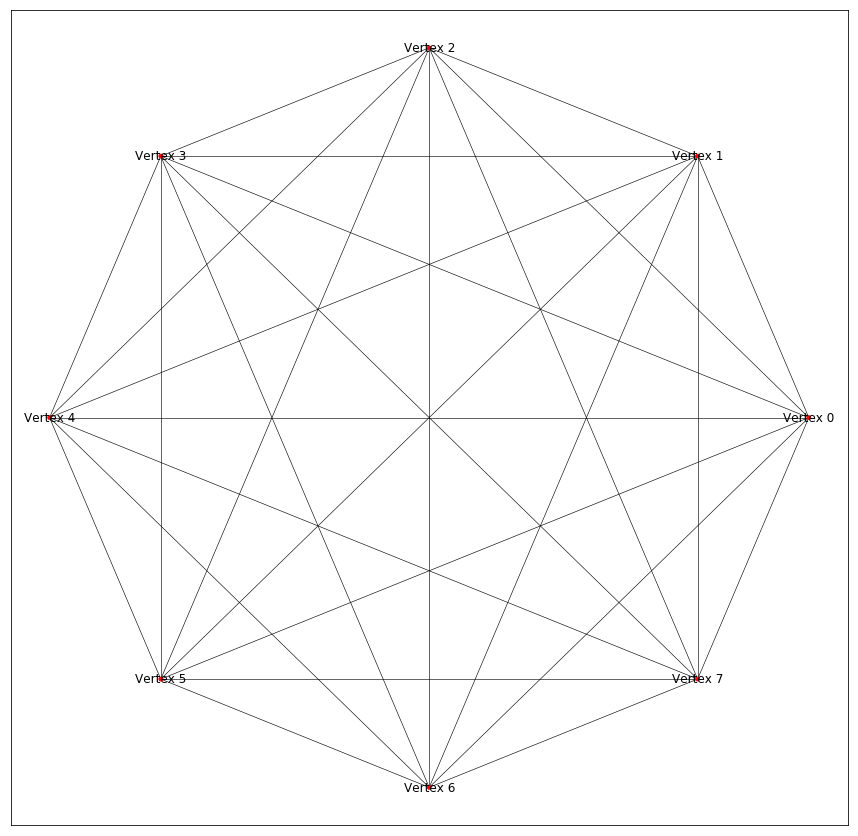

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [], Vertex 5: [], Vertex 6: [], Vertex 7: [], Vertex 8: [Vertex 2, Vertex 0, Vertex 7, Vertex 3, Vertex 1]}
Vertex 0 degree 7
[(0.40000000000000013, 0.005896641078092443, -0.004920078578092443), (-0.35555555555555585, -0.006433553829770296, 0.005065321617380075), (-0.44814814814814796, -0.006433553829770296, 0.005065321617380075), (-0.6703703703703702, -0.006433553829770296, 0.005065321617380075), (-0.5962962962962963, -0.006433553829770296, 0.005065321617380075), (-0.5222222222222221, -0.006433553829770296, 0.005065321617380075), (-0.6148148148148146, -0.006433553829770296, 0.005065321617380075), (-0.3925925925925924, -0.006433553829770296, 0.005065321617380075)]
[0.19802824196095387, -0.175929233075283, -0.22222552937157905, -0.3333366404826902, -0.2962996034456532, -0.2592625664086161, -0.3055588627049124, -0.19444775159380126]
[Vertex 8, (Vertex 8, Vertex 7), (Ver

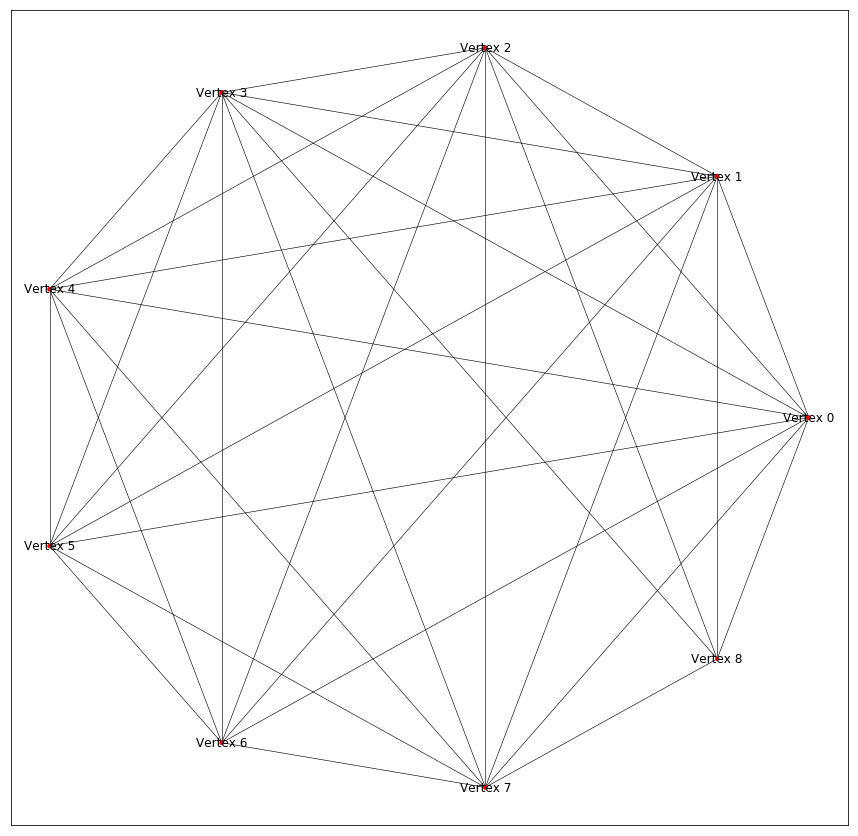

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [Vertex 8], Vertex 5: [], Vertex 6: [], Vertex 7: [], Vertex 8: [Vertex 6, Vertex 5]}
Vertex 0 had no options
Vertex 1 had no options
Vertex 2 had no options
Vertex 3 had no options
Vertex 4 had no options
Vertex 5 degree 7
[(0.5, 0.0063440683711573215, -0.005041114444165461), (-0.5925925925925921, -0.006433553829770296, 0.005065321617380075), (-0.5370370370370365, -0.006433553829770296, 0.005065321617380075), (-0.7037037037037032, -0.006433553829770296, 0.005065321617380075), (-0.7037037037037032, -0.006433553829770296, 0.005065321617380075), (-0.5370370370370365, -0.006433553829770296, 0.005065321617380075), (-0.5370370370370365, -0.006433553829770296, 0.005065321617380075), (-0.5370370370370365, -0.006433553829770296, 0.005065321617380075)]
[0.2481309197414132, -0.2944477515938011, -0.2666699738160233, -0.3500033071493567, -0.3500033071493567, -0.2666699738160233, 

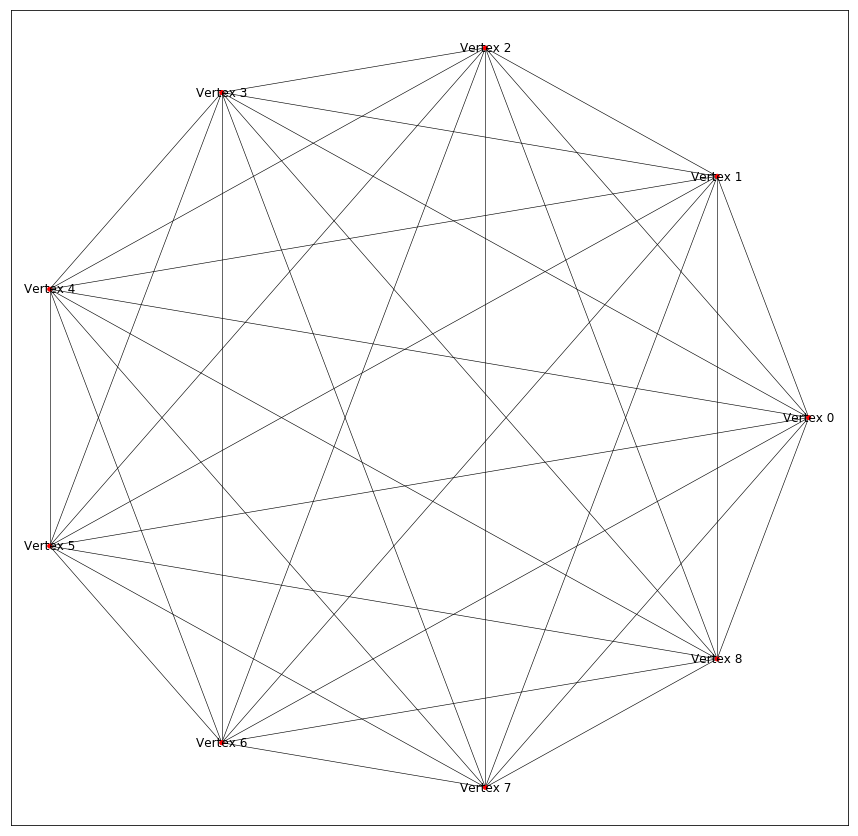

Largest component size: 9
graph density: 1.0, 

average path length: 1.0, 

diameter: 1, 

second eigenvalue: (1.1249999999999998+0j) 

-----------------------------------------
proposals: {Vertex 0: [], Vertex 1: [], Vertex 2: [], Vertex 3: [], Vertex 4: [], Vertex 5: [], Vertex 6: [], Vertex 7: [], Vertex 8: []}
Vertex 0 had no options
Vertex 1 had no options
Vertex 2 had no options
Vertex 3 had no options
Vertex 4 had no options
Vertex 5 had no options
Vertex 6 had no options
Vertex 7 had no options
Vertex 8 had no options
walk lengths {Vertex 0: 9, Vertex 1: 9, Vertex 2: 9, Vertex 3: 9, Vertex 4: 9, Vertex 5: 9, Vertex 6: 9, Vertex 7: 9, Vertex 8: 9}


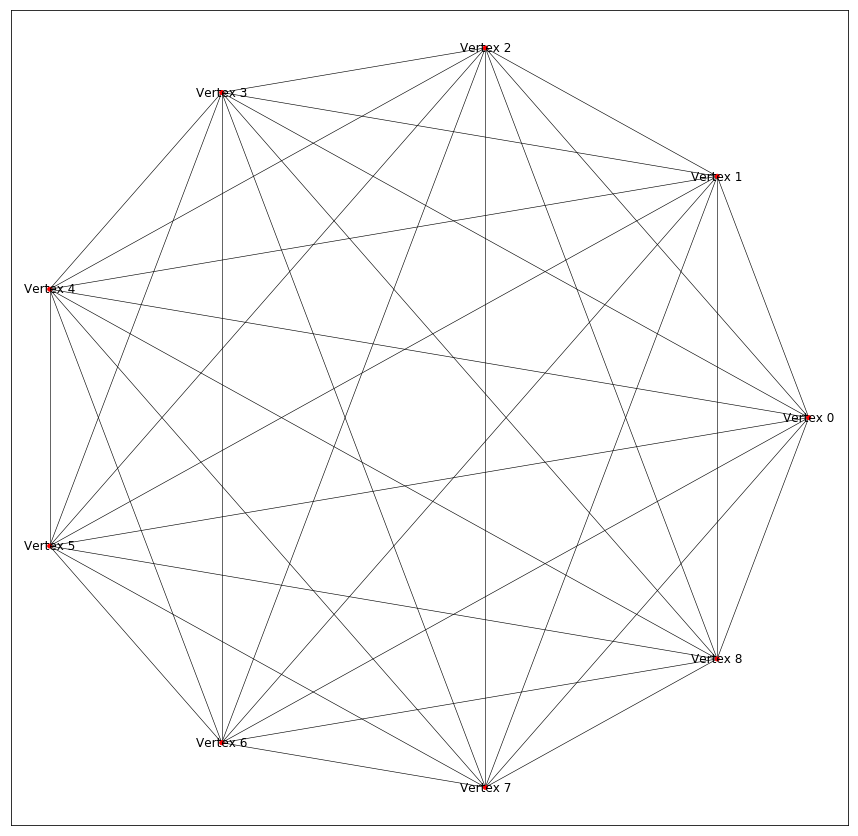

Largest component size: 9
graph density: 1.0, 

average path length: 1.0, 

diameter: 1, 

second eigenvalue: (1.1249999999999998+0j) 



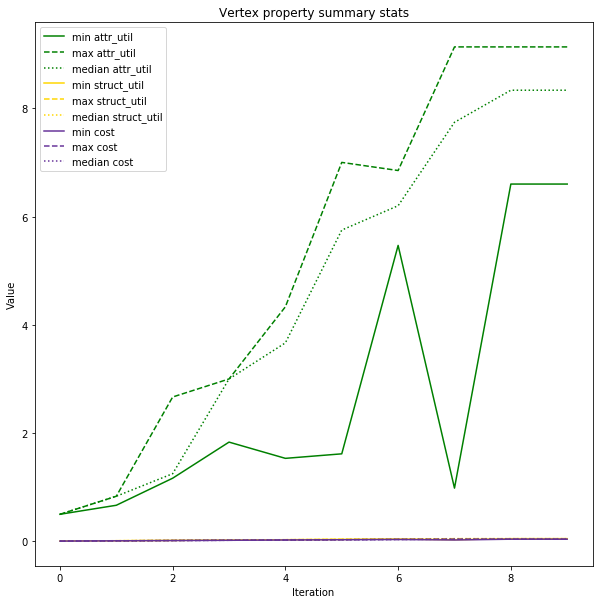

In [5]:
G = attribute_network(_N, params)
print(G.sim_params)

# Simul + some vis parameters
num_iters = 10
add_to_iter = 8
show_last = 2

summary_stat_vals = ['attr_util', 'struct_util', 'cost']
summary_funcs = [ min, max, np.median ]
summary_func_names = ['min', 'max', 'median']
summary_stats = { val : { name : [] for name in summary_func_names } \
                 for val in summary_stat_vals }
stat_val_colors = ['green', 'gold', 'rebeccapurple']
summary_func_styles = ['-', '--', ':']

for it in range(num_iters):
    if it < add_to_iter:
        add_attr_graph_vtx(G)
    calc_edges(G)
    simul_random_walk(G)
    for v in [ v for v in G.vertices if v.degree == 0 ]:
        attr_util.indep_context_proposal(G, v)
        
    # Sim iter end, start stat collection
    
    attr_util_vals = [ u.total_edge_util / G.sim_params['edge_util_func'](u, u, G) \
                      for u in G.vertices ]
    struct_util_vals = [ u.data['struct_util'](u, G) for u in G.vertices ]
    costs = [ attr_util.calc_cost(u, G) for u in G.vertices ]
    values = [attr_util_vals, struct_util_vals, costs]
    
    for si in range(len(summary_stat_vals)):
        for fi in range(len(summary_funcs)):
            ss_val = summary_funcs[fi](values[si])
            summary_stats[summary_stat_vals[si]][summary_func_names[fi]].append(ss_val)
            
    vis.draw_graph(G)
    if it >= num_iters - show_last:
        
        print_metrics(G)

plt.figure(figsize=(10,10))
x_vals = list(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel("Value")
plt.title("Vertex property summary stats")
for si in range(len(stat_val_colors)):
    for fi in range(len(summary_func_styles)):
        plt.plot(x_vals,
                 summary_stats[summary_stat_vals[si]][summary_func_names[fi]],
                 color=stat_val_colors[si],
                 linestyle=summary_func_styles[fi],
                 label='{0} {1}'.format(summary_func_names[fi], summary_stat_vals[si]))
plt.legend()
plt.show()